<div style="text-align: center">
<h2><font color="#004D7F" size=6> CNN Model for pneumonia detection </font></h2>

    
---
<a id="references"></a>

       
<font color="#004D7F" size=3>Pneumonia is one of the serious diseases that is caused by a bacterial or viral infection of the lungs and has the potential to result in severe consequences within a short period. Therefore, early diagnosis is a key factor in terms of the successful treatment process [[1]](#reference1).

Over 150,000,000 million people, mainly children under 5 years old, are infected by pneumonia anually around world [[3]](#reference3). Pneumonia has caused a significant number of deaths around the world, it's even the responsible of most of the deaths in adults globally. Also, this disease is the responsible of the death of more than 800,000 children under five years old per year. It's around 2,200 deaths per day. It converts pneumonia as the top children killer disease on earth [[2]](#reference2).

One way to diagnose pneumonia includes chest X-ray imaging, which is the most effective and economical way to diagnose. However, the task of diagnose this disease can be difficult because this kind of X-rays are used to detect many other lung deseases, as cancer or tuberculosis [[2]](#reference2). This makes the task of detecting pneumonia in a challenging task that relies on the availibility and judge of expert radiologists. 

The severity of this disease requires to be treated as it should. 
    
Nowadays, Deep Learning models for image classification are beign used for countless purposes, and one of them are for medical purposes. This models are capeable of detecting if an image presents or not an object (or multiple) of interest. For pneumonic ends, Deep Learning models can be used to detect if a chest X-ray image presents or not this disease.
    
It's important to adopt Deep Learning technologies to complement radiologists in the detection of pneumonia, given the grade of accuracy, consistency and speed that this models provides.
    
The present work have the purpose of develop a Deep Learning model which could be capeable of classify if a chest X-ray image contains a pneumonic or not. Also, the model will distinguish if, in case there is a pneumonic detected, if it is a bacterial y virus one. The model is constructed from a CNN architecture (Artificial Neural Network architecture which is specialized for image models). It also uses a MobileNetV2 pretrained neural network.
    
Remark: The purpose of this work isn't to achieve the best results by squeezing hyperparameters or developing an ultra sophisticated CNN architecture, there's already a lot of papers which already treat this topic, with state-of-the-art models and better results. The purpose is to show in practice how a relatively simple model can return awesome predictions results in the medical field (and in a lot of other fields!)
   
[Link to the dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)
</font>
    

    
---

<br><br>
<div style="text-align: right">
<font color="#004D7F" size=3>Roberto Garcés</font><br>
    
<br><br>
<div style="text-align: right">
<font color="#004D7F" size=3>rgarcesfe@gmail.com</font><br>

<h2><font color="#004D7F" size=6> Libraries to be used </font> </h2>

---


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
import os
import cv2
import random
from sklearn.utils import shuffle
import PIL
from PIL import Image, ImageOps
import matplotlib
import glob
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import metrics, layers, Model
from tensorflow.keras.applications import ResNet50V2, MobileNetV2, InceptionV3, DenseNet121, VGG19
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.models import load_model
from tensorflow.keras.layers import Activation, Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
import keras
import matplotlib.cm as cm
from IPython.display import Image, display

In [2]:
seed = 7

<h2><font color="#004D7F" size=6> Images reorganize </font> </h2>

---

<font color="#004D7F" size=3> Original data contains two folders which represents two classes; "normal" and "pneumonia". However, in pneumonia folder, files are named as the kind of infection that caused pneumonia, which could be "virus" or "bacteria". For that reason I will separate this two subcategories, so the model can predict not only the presence or not of pneumonia, but also what kind of pneumonia it's
    
Once ran the next cell there's no need to run again, so I keep it commented

</font>

In [3]:
# file_source = "chest_xray\\pneumonia\\"
# virus = "chest_xray\\virus"
# bacteria = "chest_xray\\bacteria"
# 
# if not os.path.exists('chest_xray\\virus'):
#     os.makedirs('chest_xray\\virus')
# if not os.path.exists('chest_xray\\bacteria'):
#     os.makedirs('chest_xray\\bacteria')
#     
# get_files = os.listdir(file_source)
#  
# for g in get_files:
#     if "virus" in g:
#         shutil.move(file_source + g, virus)
#     if "bacteria" in g:
#         shutil.move(file_source + g, bacteria)

<h2><font color="#004D7F" size=6> Data resize</font></h2>

---

<font color="#004D7F" size=3>I choosed this way to resize just because habit. Once done it's not needed to be ran again, because the resized images will keep saved in its folder

This cells also need to be ran just once, so I keep it commented
</font>



In [4]:
def image_resize(src_path, dst_path, shape=(255,255)):
    
    if not os.path.exists(dst_path):
        os.makedirs(dst_path)
        
    normal_image_list = []
    resized_image_list = []
    
    for filename in glob.glob(src_path+"\\*"):
        img = Image.open(filename)
        normal_image_list.append(img)
        
    for image in normal_image_list:
        image = image.resize(shape)
        resized_image_list.append(image)

    for (i, new) in enumerate(resized_image_list):
        new.save("{}{}{}".format(dst_path+'\\shape',i+1,'.png'))

In [5]:
# image_resize("chest_xray\\normal", "resized_images\\normal")
# image_resize("chest_xray\\virus", "resized_images\\virus")
# image_resize("chest_xray\\bacteria", "resized_images\\bacteria")

<h2><font color="#004D7F" size=6> Import the data</font></h2>

---

<font color="#004D7F" size=3>   We import the resized images and its labels and keep it into a pandas data frame  </font>

In [6]:
dir = "resized_images"

label = []
path = []

for dirname, _,filenames in os.walk(dir):
    for filename in filenames:
        label.append(os.path.split(dirname)[1])
        path.append(os.path.join(dirname,filename))

df = pd.DataFrame(columns=['path','label'])
df['path'] = path
df['label'] = label

# We shuffle the data because the first X elements belongs to a class and the left belongs to the other
df = shuffle(df, random_state = seed)

<h2><font color="#004D7F" size=6> Class distribution</font></h2>

---

<font color="#004D7F" size=3> </font>

In [7]:
df["label"] = df["label"].astype("category")

print(f"Total cases     : {df.shape[0]}\n")
print(f"Bacterial Pneumonia cases  : {df['label'].value_counts().bacteria} => {round(df['label'].value_counts().bacteria/len(df)*100,2)}%")
print(f"Virus Pneumonia cases      : {df['label'].value_counts().virus} => {round(df['label'].value_counts().virus/len(df)*100,2)}%")
print(f"Normal cases               : {df['label'].value_counts().normal} => {round(df['label'].value_counts().normal/len(df)*100,2)}%")

Total cases     : 5856

Bacterial Pneumonia cases  : 2780 => 47.47%
Virus Pneumonia cases      : 1493 => 25.5%
Normal cases               : 1583 => 27.03%


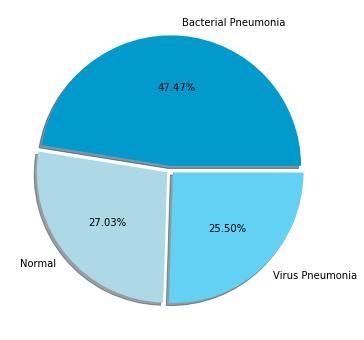

In [8]:
data = [df['label'].value_counts()[0], df['label'].value_counts()[1], df['label'].value_counts()[2]]
labels = ["Bacterial Pneumonia","Normal", "Virus Pneumonia"]
colors = ['#009ACD', '#ADD8E6', '#63D1F4']
plt.figure(figsize=(10,6))
plt.pie(data, labels=labels, colors = colors, autopct='%.2f%%', shadow=True, explode = [0.03,0.03,0.03])
plt.show()

<h2><font color="#004D7F" size=6> Check the images    </font></h2>

---

<font color="#004D7F" size=3>Let's see some random examples of the data.

P.S: I have no idea why the images are not in black and gray, I will be enourmesly appreciate if you tell me 
</font>

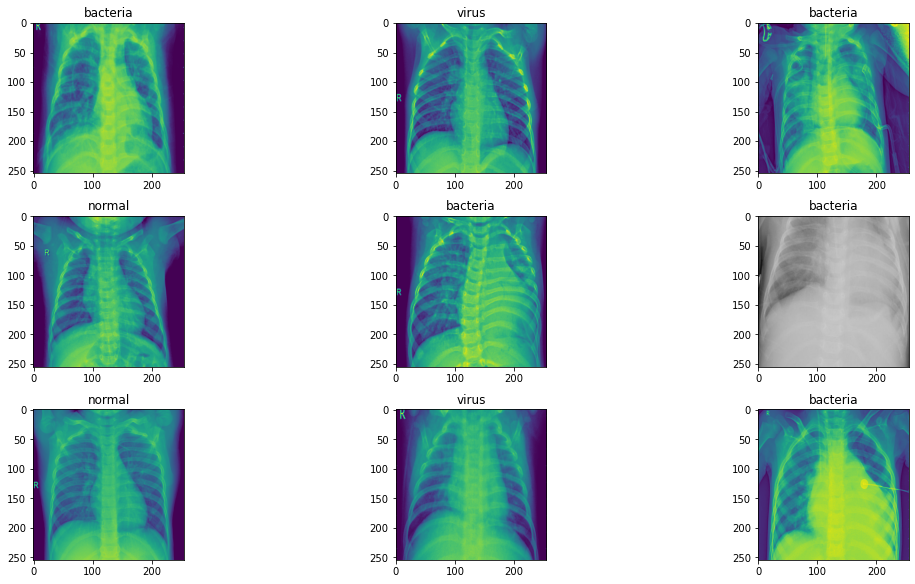

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,8), constrained_layout=True)
ax = ax.flatten()
j = 0

for i in df["label"][:9]:
    ax[j].imshow(plt.imread(df[df["label"]==i].iloc[j,0]))
    ax[j].set_title(i)
    j+=1

<h2><font color="#004D7F" size=6> Train and test split     </font></h2>

---


In [10]:
test_size = 0.3
X_train, X_test = train_test_split(df, test_size=test_size, shuffle = True, random_state = seed)
print(f"Train set size: {X_train.shape[0]} images\nTest set size : {X_test.shape[0]} images")

Train set size: 4099 images
Test set size : 1757 images


<h2><font color="#004D7F" size=6> Data preprocessing    </font></h2>

---

<font color="#004D7F" size=3>  </font>

In [11]:
trainGen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.3)
testGen =ImageDataGenerator(preprocessing_function = preprocess_input)

In [12]:
# Batch sizes for training, validation and testing
train_bs = 10
val_bs = 10
test_bs = 10

In [13]:
X_train_img = trainGen.flow_from_dataframe(dataframe=X_train, x_col='path', y_col='label',class_mode='categorical', subset='training', color_mode='rgb', batch_size=train_bs)
X_val_img = trainGen.flow_from_dataframe(dataframe=X_train, x_col='path', y_col='label',class_mode='categorical', subset='validation', color_mode='rgb', batch_size=val_bs)
X_test_img =testGen.flow_from_dataframe(dataframe=X_test, x_col='path', y_col='label',class_mode='categorical', color_mode='rgb', batch_size=test_bs, shuffle=False)

Found 2870 validated image filenames belonging to 3 classes.
Found 1229 validated image filenames belonging to 3 classes.
Found 1757 validated image filenames belonging to 3 classes.


In [14]:
print(f"Image shape: {X_test_img[0][0].shape}")
image_shape = X_test_img[0][0].shape[1:]
print(f"Class indices: {X_train_img.class_indices}")

Image shape: (10, 256, 256, 3)
Class indices: {'bacteria': 0, 'normal': 1, 'virus': 2}


<h2><font color="#004D7F" size=6> CNN Model
    </font></h2>
    
---


<font color="#004D7F" size=3> I will use a pre-trained neural network (a MobileNetV2), which will help the model to achieve better results in less epochs. Even, it could let the model achieve better results than it could ever gets without one

The hyperparameters selected were choosed by try and failure. They fit very good, but surely there is a better set of hyperparameters to choose.
</font>


In [15]:
# I choosed the MobileNetV2 because it returned the best results and the best training times. I tried with ResNet50V2,
# ResNet152, VGG19, InceptionV3 and DenseNet121, and MobileNet not only returned the best results but also was the 
# faster one on training

pre_trained = MobileNetV2(include_top=False, pooling='avg', input_shape=image_shape,)
pre_trained.trainable = False

In [16]:
# Hyperparameters 

#steps_per_epoch = int(X_train.shape[0]/train_bs)
batch_size = 64
learning_rate = 0.0001
epochs = 30
dropout = 0.5

In [17]:
# Fine-tuning: after the pre-trained neural network, tree dense layers are added up. Again, surely there is a better
# combination of hyperparameters. The objective of this work is not squeeze in hyperparams and technics, but to return
# a relatively simple model that brings excellent results.

inp_model = pre_trained.input

x = Conv2D(64, (3, 3), activation='relu', padding='same')(inp_model)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x=Flatten()(pre_trained.output)
x = Dense(128, activation='relu')(pre_trained.output) 
x = Dropout(dropout)(x)
x = Dense(64, activation='relu')(x) 
x = Dropout(dropout)(x)                          
x = Dense(64, activation='relu')(x)           
output = Dense(3, activation='softmax')(x)
model = Model(inputs=inp_model, outputs=output)
optimizer = keras.optimizers.Adam(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer= optimizer,
              metrics=['accuracy', metrics.Recall(), metrics.CategoricalAccuracy()])

In [18]:
results = model.fit(X_train_img,
                    epochs= epochs,
                    batch_size = batch_size,
                    validation_data=X_val_img)

Epoch 1/30
287/287 [==============================] - 96s 335ms/step - loss: 1.0755 - accuracy: 0.4826 - recall: 0.2843 - categorical_accuracy: 0.4826 - val_loss: 0.8437 - val_accuracy: 0.6753 - val_recall: 0.3963 - val_categorical_accuracy: 0.6753
Epoch 2/30
287/287 [==============================] - 96s 334ms/step - loss: 0.8723 - accuracy: 0.6073 - recall: 0.4348 - categorical_accuracy: 0.6073 - val_loss: 0.6942 - val_accuracy: 0.7234 - val_recall: 0.5948 - val_categorical_accuracy: 0.7234
Epoch 3/30
287/287 [==============================] - 103s 358ms/step - loss: 0.7893 - accuracy: 0.6404 - recall: 0.5251 - categorical_accuracy: 0.6404 - val_loss: 0.6527 - val_accuracy: 0.7225 - val_recall: 0.6298 - val_categorical_accuracy: 0.7225
Epoch 4/30
287/287 [==============================] - 94s 328ms/step - loss: 0.7308 - accuracy: 0.6711 - recall: 0.5707 - categorical_accuracy: 0.6711 - val_loss: 0.6298 - val_accuracy: 0.7339 - val_recall: 0.6672 - val_categorical_accuracy: 0.7339
Epo

In [ ]:
#model.save("model.h5")
#model = keras.models.load_model("model.h5")

In [19]:
result = pd.DataFrame(results.history)

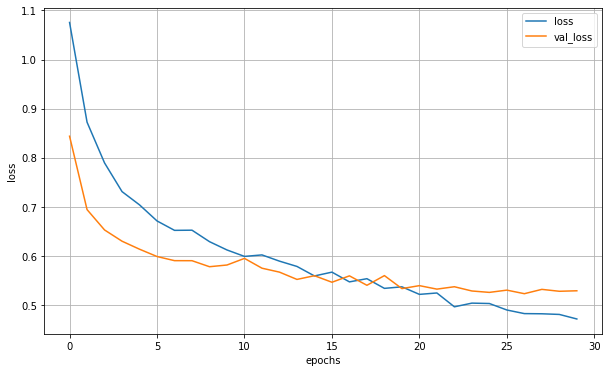

In [20]:
result[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

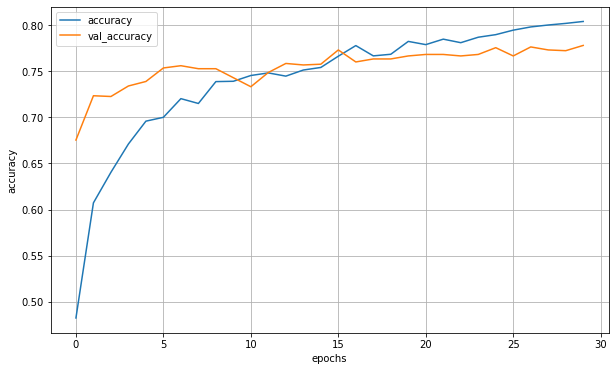

In [21]:
result[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

<h2><font color="#004D7F" size=6>Predictions and results</font></h2>

---


In [22]:
# Here I created a copy of the original dataset, where model predictions are added up for the next step; the evaluation.

preds = model.predict(X_test_img)
preds = np.argmax(preds, axis=1)   
preds_df = X_test.copy()  

In [23]:
labels = {}
for l,v in X_test_img.class_indices.items():
    labels.update({v:l})
preds_df['preds'] = preds
preds_df['preds'] = preds_df['preds'].apply(lambda x: labels[x])


Batch Size = 64
Learning Rate = 0.0001
Epochs = 30
Training Batch Size = 10
Validation Batch Size = 10
Test Batch Size = 10
Dropout rate = 0.5
Optimizer = Adam

              precision    recall  f1-score   support

    bacteria       0.77      0.87      0.82       821
      normal       0.90      0.89      0.90       469
       virus       0.68      0.53      0.59       467

    accuracy                           0.78      1757
   macro avg       0.78      0.76      0.77      1757
weighted avg       0.78      0.78      0.78      1757

Accuracy Score: 78.49%



<AxesSubplot:xlabel='preds', ylabel='label'>

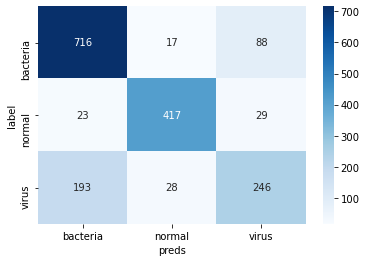

In [24]:
# Here are the results. The hyperparameters are printed in the first place, so you can take a screenshot of the results
# and its hyperparams in case you want to take this model and experiment with it. Next there are presented the 
# classification report, which tells the most used metrics, like accuracy and precision, and finally, the confussion matrix

print(f"\nBatch Size = {batch_size}\n"
          f"Learning Rate = {learning_rate}\n"
          f"Epochs = {epochs}\n"
          f"Training Batch Size = {train_bs}\n"
          f"Validation Batch Size = {val_bs}\n"
          f"Test Batch Size = {test_bs}\n"
          f"Dropout rate = {dropout}\n"
          f"Optimizer = Adam\n")

print(classification_report(preds_df["label"], preds_df["preds"]))
print(f"Accuracy Score: {round(accuracy_score(preds_df['label'],preds_df['preds'])*100,2)}%\n")
cf_matrix = pd.crosstab(preds_df["label"], preds_df["preds"])
sns.heatmap(cf_matrix, annot=True, fmt='2d', cmap = "Blues",)

<h2><font color="#004D7F" size=6> Grouping Pneumonia  </font></h2>

---

<font color="#004D7F" size=3> The recent model returned good but not excellent results. However, if you look carefully to the classification report or the confussion matrix you can tell that class '1' ('normal') haven't many misspredictions, actually it's with class '0' and '2' (bacteria and virus respectively) where the most missclasiffications are. 
    
What does this means? This means that the model is doing fine distinguishing the chest X-rays which are ok and the ones which presents pneumonia. The only thing is that at the time of predicting which kind of pneumonia it's, the model makes more mistakes (but nothing exagerated). This way, if we want to make only confident predictions, we could group bacterial and viral pneumonia just as pneumonia. This will return us better accuracy results, but it will not return the kind of pneumonia detected. Personally I don't think this approach adds much value, but it's always good to know how we can manipulate our models in order to have results that satisfies us.
    
In the next cell I'll show how this approach effectively increaces accuracy score and the other metrics we are measuring.
</font>

In [26]:
preds = model.predict(X_test_img)
preds = np.argmax(preds, axis=1)  
preds_df_grouped = X_test.copy()

In [29]:
labels = {}
for l,v in X_test_img.class_indices.items():
    labels.update({v:l})
preds_df_grouped['preds'] = preds
preds_df_grouped['preds'] = preds_df_grouped['preds'].apply(lambda x: labels[x])

              precision    recall  f1-score   support

      normal       0.90      0.89      0.90       469
   pneumonia       0.96      0.97      0.96      1288

    accuracy                           0.94      1757
   macro avg       0.93      0.93      0.93      1757
weighted avg       0.94      0.94      0.94      1757

Accuracy Score: 94.48%




<AxesSubplot:xlabel='preds', ylabel='label'>

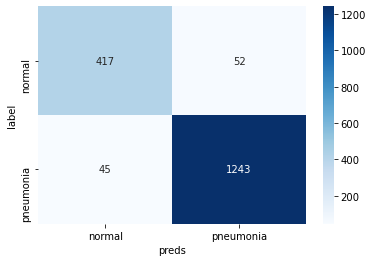

In [30]:
preds_df_grouped["label"] = preds_df_grouped["label"].str.replace("virus","pneumonia")
preds_df_grouped["label"] = preds_df_grouped["label"].str.replace("bacteria","pneumonia")
preds_df_grouped["preds"] = preds_df_grouped["preds"].str.replace("virus","pneumonia")
preds_df_grouped["preds"] = preds_df_grouped["preds"].str.replace("bacteria","pneumonia")

print(classification_report(preds_df_grouped["label"], preds_df_grouped["preds"]))
print(f"Accuracy Score: {round(accuracy_score(preds_df_grouped['label'],preds_df_grouped['preds'])*100,2)}%\n")
print()
cf_matrix = pd.crosstab(preds_df_grouped["label"], preds_df_grouped["preds"])
sns.heatmap(cf_matrix, annot=True, fmt='2d', cmap = "Blues",)

<h2><font color="#004D7F" size=6> What if we use thresholds?  </font></h2>

---

<font color="#004D7F" size=3>In case we want to increase the performance of the model we can define a confidence threshold. I'll explain. The predictions the model returns over the test images are actually the probabilities of the image belonging to a class or the other. So the results could be, for example: {"normal": 0.89, "pneumonia": 0.11}, which means the model is 89% confident that the image is on the normal class. We could want that the model gives us a prediction if the model is only 90% or more (or any other number) confident about its prediction. So, with a threshold we can define the confidence level the model should have at the time of returning its prediction to accept it or not.
    
But doing it has a cost. As you increase the confidence level the model should have to return a prediction, the less predictions you will have. So, you will have less predictions but a better performance.In the next cells we'll see how the results vary as we modify the threshold.
    
    
P.S: using or not a threshold have no impact on the model, just in what it returns. </font>

In [36]:
preds = model.predict(X_test_img)

In [37]:
# Here we define the threshold we want to use. There is no correct number, it depends only in the strategy 
# you want to take. For instance, if you want to minimize the FN (False Negative), you could increase the
# threshold to a level where the 'not suitable' predictions and FN are in equilibrium.

threshold = 0.95

In [38]:
preds_df = X_test.copy()
labels = {}
y_preds = []

In [39]:
for i in preds:
    if i[i.argmax()] >= threshold:
        i = i.argmax()
        y_preds.append(i)
    else:
        y_preds.append("Not suitable")

for l,v in X_test_img.class_indices.items():
    labels.update({v:l})
            
preds_df["preds"] = y_preds
#preds_df["preds"] = preds_df["preds"].apply(lambda x: labels[x])

In [40]:
not_suitable_index = preds_df[preds_df["preds"]=="Not suitable"].index
preds_df.drop(not_suitable_index, inplace=True)
preds_df['preds'] = preds_df['preds'].apply(lambda x: labels[x])

In [41]:
acc = accuracy_score(preds_df["label"], preds_df["preds"])

In [42]:
# In this case, we used a 90% confidence level. It increases the accuracy from 94,5% to 98,9% and reduces FN from 30 to 3,
# but the percentage of not suitable images is 38.13%. This last means that 38% of the images you will predict will not 
# retrieve any result.

print(f"\n● Confidence threshold: {threshold*100}%")
print(f"● Percentage of not suitable images: {round(len(not_suitable_index)*100/len(X_test),2)}%")
print(f"● Accuracy: {round(acc*100,2)}%\n")

print(classification_report(preds_df["label"], preds_df["preds"]))


● Confidence threshold: 95.0%
● Percentage of not suitable images: 77.86%
● Accuracy: 96.66%

              precision    recall  f1-score   support

    bacteria       0.97      0.90      0.93        39
      normal       0.97      1.00      0.98       341
       virus       0.00      0.00      0.00         9

    accuracy                           0.97       389
   macro avg       0.65      0.63      0.64       389
weighted avg       0.94      0.97      0.96       389



C:\Users\rober\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rober\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rober\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy Score: 96.66%

{'bacteria': 0, 'normal': 1, 'virus': 2}


<AxesSubplot:>

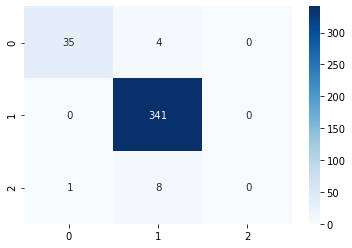

In [43]:
print(f"Accuracy Score: {round(accuracy_score(preds_df['label'],preds_df['preds'])*100,2)}%\n")
print(X_test_img.class_indices)
sns.heatmap(confusion_matrix(preds_df['label'], preds_df['preds']), annot=True, fmt='2d', cmap = "Blues")

<h2><font color="#004D7F" size=6> Visual explanations of model decision making </font></h2>

<font color="#004D7F" size=3> Deep Learning models are generally a 'black-box'; they make an excelent job at predicting, but it's almost impossible to tell whats really happening inside the model (this particular model calculates more than 2 million parameters, how can you explain a model with such number of parameters). 
    
In order to explain decisions of CNN-based models there's a very interesting technique; Grad-CAM [[5]](#reference5).. This technique produces a visual explanation which consists in ensamble an heatmap over an image, and this heat map will highlight the important regions in the image for the prediction.  

    
P.S: I took the Grad-CAM class activation visualization setup from this [Keras example](https://keras.io/examples/vision/grad_cam/)

</font>

In [44]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 255,255
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (255, 255, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 255, 255, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

model_builder = keras.applications.xception.Xception
img_size = image_shape 
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act" # You will find the last_conv_layer_name in your model summary

# The local path to our target image
img_path = df["path"][0]
#display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
#print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)


def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

normal


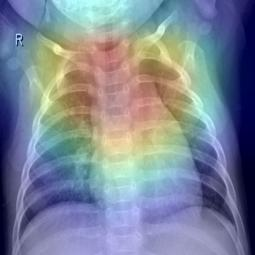

bacteria


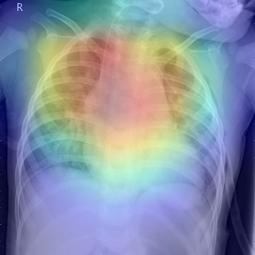

bacteria


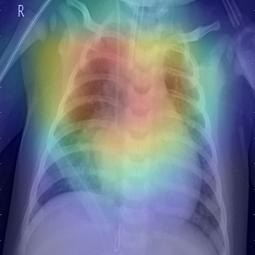

bacteria


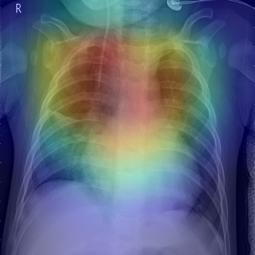

bacteria


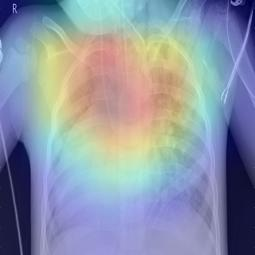

virus


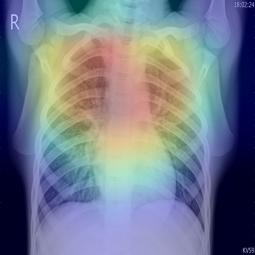

In [57]:
random_images = [random.randint(0,1000) for i in range(6)]
random_images
for i in random_images:
    print(df["label"].iloc[i])
    save_and_display_gradcam(df["path"].iloc[i], heatmap)

### <h2><font color="#004D7F" size=6> How could this model improve the results? </font></h2>

---

<font color="#004D7F" size=3>The results obtained in this work are awesome, but there's always a space to improve the performance of models. Ok, as you get better results, it becomes more difficult to still improving the model, but this marginal improvements, as little as they see they provoque great improvements. For instance, if you are getting 95% accuracy and you improve your model until getting 97,5% (only 2,5% plus), the error rate gets reduces by 50%, which is great.

Thanks to the great community of academics, data scientist and enthusiastics in this field, there are countless ways to improve models performance. You can use more sophisticated CNN architectures, choose a better set of hyperparameters, apply data preprocessing techniques (as CLAHE or data augmentation) or get more data. 
    
</font>


### <h2><font color="#004D7F" size=6> Conclusions  </font></h2>


---

<font color="#004D7F" size=3>
    
There is out there a lot of diseases that are not beign efficiently treated, which implicates in the death of millions of people around the world. Just the early detection of diseases could make the difference between a short and easy treatment and a more complicated treatment which could have fatal consequences. 
    
Because of its efficiency and great performance, Deep Learning models can be enormously helpful. With the use of this kind of models as complement, the detection of diseases can be reached early and in a more accessible and accurate way, making these diseases more treatable, which could save a lot of lives.  
    
</font>

<h2><font color="#004D7F" size=6> References  </font></h2>

---

<a id="references"></a>


<font color="#004D7F" size=3>
    
* [1] [2020] "Investigation of the performance of Machine Learning Classifiers for Pneumonia Detection in Chest X-ray Images"; Rabia Emhamed Al Mamlook, Shengfeng Chen, Hanin Fawzi Bzizi <a id="reference1"></a>


    
* [2] [2021] "Pneumonia Detection from Chest X-ray Images Based on Convolutional Neural Network"; Dejun Zhang, Fuquan Ren, Yushuang Li, Lei Na and Yue Ma <a id="reference2"></a>

    
* [3] [2020] "Intelligent Pneumonia Identification from Chest X-Rays: AbSystematic Literature Review"; Wasig Khan, Nazar Zaki, and Luqman Ali. <a id="reference3"></a>
    

* [4] [2021] "Performance analysis of Pneumonia using Convolutional Neural Networks"; Ranjith M S, Dr.Aruna Devi K, Dr. Lakshminarayana M, Dr. G. Somasekhar, Appasami G and Dr. R. Sundar Rajan. <a id="reference4"></a>
    
    
* [5] [2019] "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"; Ramprasaath R. Selvaraju, Michael Cogswell, Abhishek Das, Ramakrishna Vedantam, Devi Parikh, Dhruv Batra <a id="reference5"></a>

    
</font>